In [1]:
# Imports
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline

In [2]:
# === 0. Load Datasets ===
# 0.1 HPC dataset (Windows Behavior)
hpc_path = 'MalMem2022.csv'
hpc_df = pd.read_csv(hpc_path)
print("HPC columns:", hpc_df.columns.tolist())

# 0.2 Android datasets: emulator & real, benign vs malware
paths = {
    'emu_legit': 'emu_legitimate_v1.csv',
    'emu_mal':   'emu_malware_v1.csv',
    'real_legit': 'real_legitimate_v1.csv',
    'real_mal':  'real_malware_v1.csv'
}
android_parts = []
for name, p in paths.items():
    df = pd.read_csv(p)
    label = 0 if 'legit' in name else 1
    df['label'] = label
    android_parts.append(df)
android_df = pd.concat(android_parts, ignore_index=True)
print("Android columns:", android_df.columns.tolist())

HPC columns: ['pslist.nproc', 'pslist.nppid', 'pslist.avg_threads', 'pslist.nprocs64bit', 'pslist.avg_handlers', 'dlllist.ndlls', 'dlllist.avg_dlls_per_proc', 'handles.nhandles', 'handles.avg_handles_per_proc', 'handles.nport', 'handles.nfile', 'handles.nevent', 'handles.ndesktop', 'handles.nkey', 'handles.nthread', 'handles.ndirectory', 'handles.nsemaphore', 'handles.ntimer', 'handles.nsection', 'handles.nmutant', 'ldrmodules.not_in_load', 'ldrmodules.not_in_init', 'ldrmodules.not_in_mem', 'ldrmodules.not_in_load_avg', 'ldrmodules.not_in_init_avg', 'ldrmodules.not_in_mem_avg', 'malfind.ninjections', 'malfind.commitCharge', 'malfind.protection', 'malfind.uniqueInjections', 'psxview.not_in_pslist', 'psxview.not_in_eprocess_pool', 'psxview.not_in_ethread_pool', 'psxview.not_in_pspcid_list', 'psxview.not_in_csrss_handles', 'psxview.not_in_session', 'psxview.not_in_deskthrd', 'psxview.not_in_pslist_false_avg', 'psxview.not_in_eprocess_pool_false_avg', 'psxview.not_in_ethread_pool_false_avg

Using 'Class' as label for HPC data
HPC Epoch 1/10, Loss=0.0219
HPC Epoch 1/10, Loss=0.0219
HPC Epoch 2/10, Loss=0.0043
HPC Epoch 2/10, Loss=0.0043
HPC Epoch 3/10, Loss=0.0057
HPC Epoch 3/10, Loss=0.0057
HPC Epoch 4/10, Loss=0.0037
HPC Epoch 4/10, Loss=0.0037
HPC Epoch 5/10, Loss=0.0015
HPC Epoch 5/10, Loss=0.0015
HPC Epoch 6/10, Loss=0.0012
HPC Epoch 6/10, Loss=0.0012
HPC Epoch 7/10, Loss=0.0010
HPC Epoch 7/10, Loss=0.0010
HPC Epoch 8/10, Loss=0.0023
HPC Epoch 8/10, Loss=0.0023
HPC Epoch 9/10, Loss=0.0008
HPC Epoch 9/10, Loss=0.0008
HPC Epoch 10/10, Loss=0.0006
HPC Epoch 10/10, Loss=0.0006
HPC Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5860
           1       1.00      1.00      1.00      5860

    accuracy                           1.00     11720
   macro avg       1.00      1.00      1.00     11720
weighted avg       1.00      1.00      1.00     11720

HPC Test Accuracy: 0.9998
HPC Classification Rep

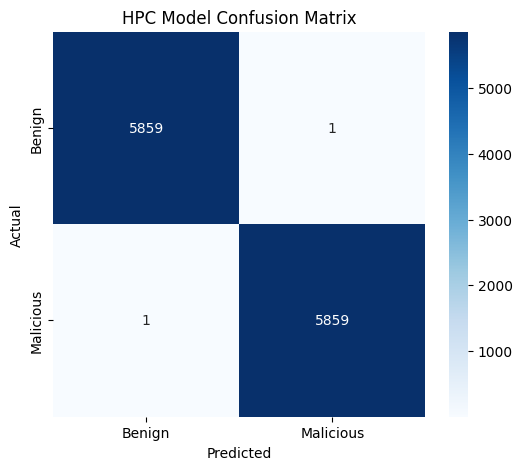

In [3]:
# === 1. Preprocess HPC Data ===
# Identify binary label column (object with two unique values) or assume 'Class'
if 'Class' in hpc_df.columns:
    label_col_hpc = 'Class'
elif 'Category' in hpc_df.columns:
    label_col_hpc = 'Category'
else:
    obj_cols = hpc_df.select_dtypes(include=['object']).columns.tolist()
    label_col_hpc = next(c for c in obj_cols if hpc_df[c].nunique()==2)
print(f"Using '{label_col_hpc}' as label for HPC data")

# Map label: assume benign/malicious mapping
y_hpc = hpc_df[label_col_hpc].map(lambda x: 0 if 'benign' in str(x).lower() else 1)
# Drop non-numeric cols
num_cols = hpc_df.select_dtypes(include=[np.number]).columns.tolist()
X_hpc = hpc_df[num_cols]

# Scale and reshape
scaler = StandardScaler()
Xh = scaler.fit_transform(X_hpc)
Xh_train, Xh_test, yh_train, yh_test = train_test_split(
    Xh, y_hpc, test_size=0.2, random_state=42, stratify=y_hpc)
Xh_train = Xh_train[:,:,np.newaxis]
Xh_test  = Xh_test[:,:,np.newaxis]

# PyTorch dataset & loader
class HPCDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values if hasattr(y,'values') else y, dtype=torch.long)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_h = HPCDataset(Xh_train, yh_train)
test_h  = HPCDataset(Xh_test, yh_test)
loader_h_train = DataLoader(train_h, batch_size=64, shuffle=True)
loader_h_test  = DataLoader(test_h, batch_size=64)

# 1D-CNN for HPC
class HPC1DCNN(nn.Module):
    def __init__(self, num_feat):
        super().__init__()
        self.conv1 = nn.Conv1d(1,16,3,padding=1)
        self.pool  = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(16,32,3,padding=1)
        self.fc1   = nn.Linear((num_feat//4)*32,64)
        self.fc2   = nn.Linear(64,2)
    def forward(self,x):
        x = x.permute(0,2,1)
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.flatten(1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

model_h = HPC1DCNN(Xh_train.shape[1])
opt_h = torch.optim.Adam(model_h.parameters(), lr=1e-3)
crit = nn.CrossEntropyLoss()

epochs = 10
for ep in range(epochs):
    model_h.train(); total_loss=0
    for Xb,yb in loader_h_train:
        opt_h.zero_grad()
        out = model_h(Xb)
        loss = crit(out, yb)
        loss.backward(); opt_h.step()
        total_loss += loss.item()
    print(f"HPC Epoch {ep+1}/{epochs}, Loss={total_loss/len(loader_h_train):.4f}")

# Evaluate HPC
model_h.eval(); preds_h, labs_h = [],[]
with torch.no_grad():
    for Xb,yb in loader_h_test:
        out = model_h(Xb)
        preds_h += out.argmax(1).tolist()
        labs_h  += yb.tolist()
# Print classification report and accuracy
print("HPC Classification Report:")
print(classification_report(labs_h, preds_h))
acc_h = accuracy_score(labs_h, preds_h)
print(f"HPC Test Accuracy: {acc_h:.4f}")

# Plot confusion matrix for HPC model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(labs_h, preds_h)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign','Malicious'], yticklabels=['Benign','Malicious'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('HPC Model Confusion Matrix')
plt.show()


Target: Category
Category
Benign                  29298
Spyware-Transponder      2410
Spyware-Gator            2200
Ransomware-Shade         2128
Spyware-CWS              2000
Trojan-Scar              2000
Spyware-180solutions     2000
Ransomware-Ako           2000
Trojan-Refroso           2000
Ransomware-Conti         1988
Trojan-Emotet            1967
Ransomware-Maze          1958
Trojan-Zeus              1950
Ransomware-Pysa          1717
Trojan-Reconyc           1570
Spyware-TIBS             1410
Name: count, dtype: int64
Number of classes: 16
Numeric features: 55
Train/test shapes: (46876, 55) (11720, 55)
Train/test shapes: (46876, 55) (11720, 55)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7658
[LightGBM] [Info] Number of data points in the train set: 46876, number of used features: 51
[LightGBM] [Info] Start training from score -2.772

c:\Users\anvit\Desktop\SEM_5\ML\ML Project\ML Code\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Test Accuracy: 0.7779, Macro F1: 0.5840
Classification report (per-class):
                      precision    recall  f1-score   support

              Benign       1.00      1.00      1.00      5860
      Ransomware-Ako       0.41      0.34      0.37       400
    Ransomware-Conti       0.52      0.45      0.48       398
     Ransomware-Maze       0.57      0.54      0.56       392
     Ransomware-Pysa       0.47      0.38      0.42       343
    Ransomware-Shade       0.52      0.53      0.53       426
Spyware-180solutions       0.46      0.43      0.45       400
         Spyware-CWS       0.47      0.45      0.46       400
       Spyware-Gator       0.59      0.79      0.68       440
        Spyware-TIBS       0.83      0.79      0.81       282
 Spyware-Transponder       0.51      0.49      0.50       482
       Trojan-Emotet       0.57      0.54      0.56       393
      Trojan-Reconyc       0.62      0.72      0.67       314
      Trojan-Refroso       0.75      0.81      0.78     

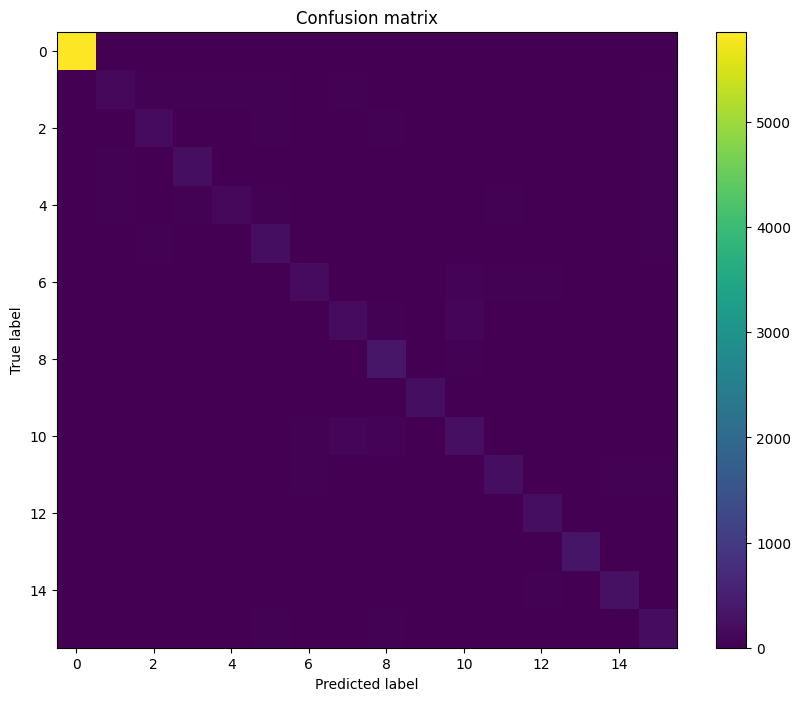

,feature,importance
0,handles.nkey,18357
1,pslist.avg_threads,16366
2,handles.nfile,14866
3,handles.nthread,14779
4,ldrmodules.not_in_init_avg,14043
5,ldrmodules.not_in_load_avg,12688
6,handles.nsection,12018
7,dlllist.avg_dlls_per_proc,11609
8,handles.nevent,11287
9,pslist.avg_handlers,9293


Model and label encoder saved.


In [5]:
# Full multiclass training pipeline for MalMem2022 (16 classes)
# Paste and run in your notebook environment (it will use full dataset).
# Optional: install lightgbm and imbalanced-learn for best results:
# pip install lightgbm imbalanced-learn

import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Optional imports (uncomment if installed)
use_smote = False   # set True if you want to try SMOTE oversampling
use_lightgbm = True # set False to force RandomForest
try:
    import lightgbm as lgb
except Exception as e:
    use_lightgbm = False
    print("LightGBM not available, will use RandomForest.")

try:
    if use_smote:
        from imblearn.over_sampling import SMOTE
except Exception as e:
    use_smote = False
    print("imbalanced-learn not available, disabling SMOTE.")

# Load data
df = pd.read_csv('MalMem2022.csv')

# Choose target - ensure 'Category' is used
target = 'Category' if 'Category' in df.columns else 'Class'
print("Target:", target)
print(df[target].value_counts())

# Encode target
le = LabelEncoder()
y = le.fit_transform(df[target].astype(str))
class_names = le.classes_
n_classes = len(class_names)
print("Number of classes:", n_classes)

# Features: numeric only for now (include other features if informative)
X = df.select_dtypes(include=[np.number]).copy()
# drop target column if numeric
if target in X.columns: X = X.drop(columns=[target])
print("Numeric features:", X.shape[1])

# Impute missing
imp = SimpleImputer(strategy='median')
X_imp = imp.fit_transform(X)

# Optionally scale for neural models; not necessary for tree boosters
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imp)

# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
print("Train/test shapes:", X_train.shape, X_test.shape)

# Apply SMOTE (optional) to training set only
if use_smote:
    sm = SMOTE(random_state=42, n_jobs=-1)
    X_train, y_train = sm.fit_resample(X_train, y_train)
    print("After SMOTE, train shape:", X_train.shape, "Class counts:", np.bincount(y_train))

# Choose model
if use_lightgbm:
    lgb_params = {
        'objective':'multiclass',
        'num_class': n_classes,
        'metric':'multi_logloss',
        'verbosity': -1,
        'seed': 42
    }
    # quick LightGBM (you can use lgb.cv or sklearn wrapper for tuning)
    model = lgb.LGBMClassifier(objective='multiclass', num_class=n_classes,
                               n_estimators=500, learning_rate=0.05, num_leaves=31,
                               class_weight='balanced')  # try class_weight
else:
    model = RandomForestClassifier(n_estimators=300, class_weight='balanced', n_jobs=-1, random_state=42)

# Fit
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average='macro')
print(f"Test Accuracy: {acc:.4f}, Macro F1: {macro_f1:.4f}")
print("Classification report (per-class):")
print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
plt.imshow(cm, interpolation='nearest', aspect='auto')
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

# Optional: top feature importances for tree models
if hasattr(model, 'feature_importances_'):
    fi = model.feature_importances_
    idx = np.argsort(fi)[::-1][:20]
    feat_imp = pd.DataFrame({'feature': X.columns[idx], 'importance': fi[idx]})
    display(feat_imp)

# Save model & encoder for reuse
import joblib
joblib.dump(model, 'malmem_model.pkl')
joblib.dump(le, 'label_encoder.pkl')
print("Model and label encoder saved.")


In [8]:
# Full pipeline with robust LightGBM early-stopping handling + hierarchical classifier
# Paste and run in your notebook.

import pandas as pd, numpy as np, time, joblib, warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

warnings.filterwarnings("ignore")

# ---------- USER-CONFIG ----------
PATH = "MalMem2022.csv"   # dataset path
USE_LIGHTGBM = True                # set False if LightGBM not installed
MULTI_N_ESTIMATORS = 600
MAL_N_ESTIMATORS   = 600
BIN_N_ESTIMATORS   = 400
LEARNING_RATE      = 0.05
EARLY_STOP_ROUNDS  = 50
RANDOM_STATE       = 42
# ---------------------------------

# Load dataset
df = pd.read_csv(PATH)
print("Loaded dataset:", PATH, "shape:", df.shape)

# Determine target column
if 'Category' in df.columns:
    target = 'Category'
elif 'category' in df.columns:
    target = 'category'
elif 'Class' in df.columns:
    target = 'Class'
else:
    raise ValueError("No obvious target column found; please set 'Category' or 'Class' in dataset.")
print("Target column:", target)
print(df[target].value_counts())

# Encode labels
le = LabelEncoder()
y_all = le.fit_transform(df[target].astype(str))
class_names = le.classes_
n_classes = len(class_names)
print("Number of classes:", n_classes)

# Identify benign class index (case-insensitive match 'benign'), fallback to most frequent class
benign_idx = None
for i, c in enumerate(class_names):
    if 'benign' in c.lower():
        benign_idx = i
        break
if benign_idx is None:
    counts = pd.Series(y_all).value_counts()
    benign_idx = int(counts.idxmax())
print("Detected benign index:", benign_idx, "label:", class_names[benign_idx])

# Select numeric features only (trees do not require scaling)
X = df.select_dtypes(include=[np.number]).copy()
if target in X.columns:
    X = X.drop(columns=[target])
print("Numeric features count:", X.shape[1])

# Impute missing numeric values with median
imp = SimpleImputer(strategy='median')
X_imp = imp.fit_transform(X)

# Stratified train/test split
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_STATE)
for train_idx, test_idx in sss.split(X_imp, y_all):
    X_tr, X_te = X_imp[train_idx], X_imp[test_idx]
    y_tr, y_te = y_all[train_idx], y_all[test_idx]
print("Train shape:", X_tr.shape, "Test shape:", X_te.shape)

# Compute sample weights (inverse class frequency) for multiclass training
unique, counts = np.unique(y_tr, return_counts=True)
class_weights = {int(k): float(len(y_tr) / (len(unique) * counts[i])) for i, k in enumerate(unique)}
sample_weights = np.array([class_weights[int(y)] for y in y_tr])
print("Example class weights:", list(class_weights.items())[:8])

# Try to import LightGBM
use_lgb = USE_LIGHTGBM
if use_lgb:
    try:
        import lightgbm as lgb
        from lightgbm import LGBMClassifier
        print("LightGBM imported, version:", lgb.__version__)
    except Exception as e:
        print("LightGBM import failed:", e)
        use_lgb = False

# Define helper for robust early stopping (only if LightGBM is available)
def lgb_fit_with_earlystop(model, X_train, y_train, X_val=None, y_val=None,
                           sample_weight=None, eval_metric=None, early_stop=50, verbose=False):
    """
    Tries multiple .fit() call signatures to enable early stopping in different LGB versions.
    If LightGBM is not available or early stop fails, will fall back to a plain .fit().
    """
    # If LightGBM not available, just call fit (this helper shouldn't be used in that case)
    if not use_lgb:
        return model.fit(X_train, y_train, sample_weight=sample_weight)

    try:
        # Newer/older wrappers may accept early_stopping_rounds directly
        model.fit(X_train, y_train,
                  sample_weight=sample_weight,
                  eval_set=[(X_val, y_val)] if (X_val is not None and y_val is not None) else None,
                  eval_metric=eval_metric,
                  early_stopping_rounds=early_stop,
                  verbose=verbose)
        return model
    except TypeError:
        # Try callback-based API
        try:
            model.fit(X_train, y_train,
                      sample_weight=sample_weight,
                      eval_set=[(X_val, y_val)] if (X_val is not None and y_val is not None) else None,
                      eval_metric=eval_metric,
                      callbacks=[lgb.early_stopping(early_stop), lgb.log_evaluation(0)])
            return model
        except Exception as e2:
            # Last resort: plain fit (no early stopping)
            print("Warning: couldn't enable early stopping; fitting without early stop. Err:", e2)
            model.fit(X_train, y_train, sample_weight=sample_weight,
                      eval_set=[(X_val, y_val)] if (X_val is not None and y_val is not None) else None,
                      eval_metric=eval_metric, verbose=verbose)
            return model

results = {}

# ---------- 1) Multiclass model (full multiclass on all labels) ----------
if use_lgb:
    print("\nTraining LightGBM multiclass on all classes...")
    multi = LGBMClassifier(objective='multiclass', num_class=n_classes,
                           n_estimators=MULTI_N_ESTIMATORS, learning_rate=LEARNING_RATE,
                           num_leaves=64, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1)
    t0 = time.time()
    multi = lgb_fit_with_earlystop(multi, X_tr, y_tr, X_te, y_te, sample_weight=sample_weights,
                                   eval_metric='multi_logloss', early_stop=EARLY_STOP_ROUNDS, verbose=False)
    elapsed = time.time() - t0
    print(f"Multiclass LightGBM trained in {elapsed:.1f}s")
    y_pred_multi = multi.predict(X_te)
    acc_multi = accuracy_score(y_te, y_pred_multi)
    f1m_multi = f1_score(y_te, y_pred_multi, average='macro')
    results['multiclass'] = (multi, acc_multi, f1m_multi)
    print("Multiclass Test Accuracy: {:.4f}, Macro F1: {:.4f}".format(acc_multi, f1m_multi))
    print(classification_report(y_te, y_pred_multi, target_names=class_names, zero_division=0))
    joblib.dump(multi, "lgb_multiclass_model.joblib")
else:
    from sklearn.ensemble import RandomForestClassifier
    print("\nLightGBM not available — training RandomForest multiclass fallback...")
    rf = RandomForestClassifier(n_estimators=300, class_weight='balanced', n_jobs=-1, random_state=RANDOM_STATE)
    t0 = time.time()
    rf.fit(X_tr, y_tr)
    elapsed = time.time() - t0
    print(f"RF trained in {elapsed:.1f}s")
    y_pred_multi = rf.predict(X_te)
    acc_multi = accuracy_score(y_te, y_pred_multi)
    f1m_multi = f1_score(y_te, y_pred_multi, average='macro')
    results['multiclass_rf'] = (rf, acc_multi, f1m_multi)
    print("RF multiclass Test Accuracy: {:.4f}, Macro F1: {:.4f}".format(acc_multi, f1m_multi))
    print(classification_report(y_te, y_pred_multi, target_names=class_names, zero_division=0))
    joblib.dump(rf, "rf_multiclass_model.joblib")

# ---------- 2) Hierarchical approach: binary (benign vs malware) -> malware-only multiclass ----------
print("\nTraining hierarchical (binary -> malware-only multiclass) approach...")

# Binary labels: 0 = benign, 1 = malware
yb_tr = (y_tr != benign_idx).astype(int)
yb_te = (y_te != benign_idx).astype(int)

if use_lgb:
    # Binary classifier
    print("Training LightGBM binary classifier...")
    bin_clf = LGBMClassifier(objective='binary', n_estimators=BIN_N_ESTIMATORS, learning_rate=LEARNING_RATE,
                             num_leaves=64, is_unbalance=True, random_state=RANDOM_STATE, n_jobs=-1)
    t0 = time.time()
    bin_clf = lgb_fit_with_earlystop(bin_clf, X_tr, yb_tr, X_te, yb_te,
                                     sample_weight=None, eval_metric='binary_logloss',
                                     early_stop=max(10, EARLY_STOP_ROUNDS//4), verbose=False)
    print("Binary classifier trained in {:.1f}s".format(time.time()-t0))
else:
    from sklearn.ensemble import RandomForestClassifier
    print("Training RandomForest binary classifier (fallback)...")
    bin_clf = RandomForestClassifier(n_estimators=200, class_weight='balanced', n_jobs=-1, random_state=RANDOM_STATE)
    bin_clf.fit(X_tr, yb_tr)

# Prepare malware-only data from training set
mal_mask = (y_tr != benign_idx)
X_tr_mal = X_tr[mal_mask]
y_tr_mal = y_tr[mal_mask]
malware_classes = np.unique(y_tr_mal)
print("Malware-only training samples:", X_tr_mal.shape[0], "unique malware classes:", len(malware_classes))

# Map global malware class labels -> local indices 0..K-1
mal_map_to_local = {int(c): i for i, c in enumerate(malware_classes)}
y_tr_mal_local = np.array([mal_map_to_local[int(c)] for c in y_tr_mal])

# Sample weights for malware-only multiclass (inverse freq)
u_m, cnts_m = np.unique(y_tr_mal_local, return_counts=True)
cw_m = {int(k): float(len(y_tr_mal_local) / (len(u_m) * cnts_m[i])) for i, k in enumerate(u_m)}
sw_m = np.array([cw_m[int(y)] for y in y_tr_mal_local])

# Train malware-only multiclass model
if use_lgb:
    print("Training LightGBM multiclass on malware-only classes...")
    mal_clf = LGBMClassifier(objective='multiclass', num_class=len(malware_classes),
                             n_estimators=MAL_N_ESTIMATORS, learning_rate=LEARNING_RATE,
                             num_leaves=64, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1)
    t0 = time.time()
    mal_clf = lgb_fit_with_earlystop(mal_clf, X_tr_mal, y_tr_mal_local, X_tr_mal, y_tr_mal_local,
                                     sample_weight=sw_m, eval_metric='multi_logloss',
                                     early_stop=max(10, EARLY_STOP_ROUNDS//4), verbose=False)
    print("Malware-only multiclass trained in {:.1f}s".format(time.time()-t0))
else:
    print("Training RandomForest multiclass on malware-only classes (fallback)...")
    mal_clf = RandomForestClassifier(n_estimators=250, class_weight='balanced', n_jobs=-1, random_state=RANDOM_STATE)
    mal_clf.fit(X_tr_mal, y_tr_mal_local)

# Evaluate hierarchical pipeline on test set
bin_preds = bin_clf.predict(X_te)

# Initialize final predictions as benign
final_preds = np.full_like(y_te, fill_value=benign_idx)

# For samples predicted malware by binary classifier, predict subtype using mal_clf
mal_test_mask = (bin_preds == 1)
if mal_test_mask.sum() > 0:
    X_mal_test = X_te[mal_test_mask]
    mal_local_preds = mal_clf.predict(X_mal_test)
    # Map local indices back to global label indices (malware_classes)
    mapped_global = np.array([malware_classes[int(x)] for x in mal_local_preds])
    final_preds[mal_test_mask] = mapped_global

# Metrics
acc_hier = accuracy_score(y_te, final_preds)
f1_hier_macro = f1_score(y_te, final_preds, average='macro')
print("Hierarchical Test Accuracy: {:.4f}, Macro F1: {:.4f}".format(acc_hier, f1_hier_macro))
print("Hierarchical classification report:")
print(classification_report(y_te, final_preds, target_names=class_names, zero_division=0))

# Save models & encoders
joblib.dump({
    'multiclass_model': results.get('multiclass', (None, None, None))[0] if 'multiclass' in results else None,
    'hier_binary': bin_clf,
    'hier_mal': mal_clf,
    'mal_map_to_local': mal_map_to_local,
    'label_encoder': le,
    'imputer': imp
}, "malmem_pipeline_models.joblib")
print("Saved pipeline artifacts to malmem_pipeline_models.joblib")

print("\nDone. Summary:")
if 'multiclass' in results:
    m, acc_m, f1_m = results['multiclass']
    print("  - Multiclass LGB: acc {:.4f}, macro_f1 {:.4f}".format(acc_m, f1_m))
print("  - Hierarchical: acc {:.4f}, macro_f1 {:.4f}".format(acc_hier, f1_hier_macro))


Loaded dataset: MalMem2022.csv shape: (58596, 58)
Target column: Category
Category
Benign                  29298
Spyware-Transponder      2410
Spyware-Gator            2200
Ransomware-Shade         2128
Spyware-CWS              2000
Trojan-Scar              2000
Spyware-180solutions     2000
Ransomware-Ako           2000
Trojan-Refroso           2000
Ransomware-Conti         1988
Trojan-Emotet            1967
Ransomware-Maze          1958
Trojan-Zeus              1950
Ransomware-Pysa          1717
Trojan-Reconyc           1570
Spyware-TIBS             1410
Name: count, dtype: int64
Number of classes: 16
Detected benign index: 0 label: Benign
Numeric features count: 55
Train shape: (46876, 55) Test shape: (11720, 55)
Example class weights: [(0, 0.125), (1, 1.83109375), (2, 1.8426100628930817), (3, 1.8708492975734354), (4, 2.132278020378457), (5, 1.7213572267920094), (6, 1.83109375), (7, 1.83109375)]
LightGBM imported, version: 4.6.0

Training LightGBM multiclass on all classes...
[Light

In [ ]:
# Multi-experiment pipeline: oversampling, Optuna tuning (macro-F1), best LGB, stacking
# Paste this entire cell into your notebook and run.

import warnings, time, joblib
warnings.filterwarnings("ignore")

import numpy as np, pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingClassifier
import matplotlib.pyplot as plt

# Optional libs - install if necessary
try:
    import lightgbm as lgb
    from lightgbm import LGBMClassifier
    LGB_AVAILABLE = True
except Exception as e:
    LGB_AVAILABLE = False
    print("LightGBM not available:", e)

try:
    import optuna
    OPTUNA_AVAILABLE = True
except Exception as e:
    OPTUNA_AVAILABLE = False
    print("Optuna not available:", e)

try:
    from imblearn.over_sampling import RandomOverSampler, SMOTE
    IMBLEARN_AVAILABLE = True
except Exception as e:
    IMBLEARN_AVAILABLE = False
    print("imblearn not available:", e)

# ---------------- USER CONFIG ----------------
PATH = "MalMem2022.csv"
RANDOM_STATE = 42
OPTUNA_TRIALS = 15         # Start small (20). Increase to 50-100 for better tuning.
CV_FOLDS = 2
OVERSAMPLE_METHOD = "smote"  # options: "none", "ros", "smote"
STACKING = True
# ---------------------------------------------

# Load & basic preprocess (numeric features only)
df = pd.read_csv(PATH)
print("Dataset shape:", df.shape)
target = 'Category' if 'Category' in df.columns else ('category' if 'category' in df.columns else 'Class')
print("Target:", target)
le = LabelEncoder()
y_all = le.fit_transform(df[target].astype(str))
class_names = le.classes_
n_classes = len(class_names)
print("n_classes:", n_classes)
# find benign index
benign_idx = None
for i,c in enumerate(class_names):
    if 'benign' in c.lower():
        benign_idx = i; break
if benign_idx is None:
    benign_idx = int(pd.Series(y_all).value_counts().idxmax())
print("benign_idx:", benign_idx, "=>", class_names[benign_idx])

# numeric features
Xdf = df.select_dtypes(include=[np.number]).copy()
if target in Xdf.columns: Xdf = Xdf.drop(columns=[target])
print("Numeric features:", Xdf.shape[1])

# impute
imp = SimpleImputer(strategy="median")
X_imp = imp.fit_transform(Xdf)

# train/test split stratified
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_STATE)
for tr_idx, te_idx in sss.split(X_imp, y_all):
    X_tr, X_te = X_imp[tr_idx], X_imp[te_idx]
    y_tr, y_te = y_all[tr_idx], y_all[te_idx]

print("Train/test shapes:", X_tr.shape, X_te.shape)

# Optional oversampling on training only
if OVERSAMPLE_METHOD == "none" or not IMBLEARN_AVAILABLE:
    print("No oversampling (or imblearn not available).")
    X_tr_os, y_tr_os = X_tr, y_tr
elif OVERSAMPLE_METHOD == "ros":
    print("Applying RandomOverSampler to training set...")
    ros = RandomOverSampler(random_state=RANDOM_STATE)
    X_tr_os, y_tr_os = ros.fit_resample(X_tr, y_tr)
    print("After ROS:", np.bincount(y_tr_os))
elif OVERSAMPLE_METHOD == "smote":
    print("Applying SMOTE to training set (may be slow/high-dim risk)...")
    # small precaution: if very high-dim, consider PCA before SMOTE
    from imblearn.over_sampling import SMOTE
    sm = SMOTE(random_state=RANDOM_STATE, k_neighbors=3)
    X_tr_os, y_tr_os = sm.fit_resample(X_tr, y_tr)
    print("After SMOTE:", np.bincount(y_tr_os))
    X_tr_os, y_tr_os = sm.fit_resample(X_tr, y_tr)
    print("After SMOTE:", np.bincount(y_tr_os))
else:
    raise ValueError("Unknown OVERSAMPLE_METHOD")

# compute sample weights inverse-freq (useful for LightGBM)
unique, counts = np.unique(y_tr_os, return_counts=True)
class_weights = {int(k): float(len(y_tr_os) / (len(unique) * counts[i])) for i,k in enumerate(unique)}
sw_train = np.array([class_weights[int(y)] for y in y_tr_os])

# ---------------- LightGBM early stop helper ----------------
def lgb_fit_with_earlystop(model, X_train, y_train, X_valid=None, y_valid=None,
                           sample_weight=None, eval_metric=None, early_stop=50, verbose=False):
    if not LGB_AVAILABLE:
        return model.fit(X_train, y_train)
    try:
        model.fit(X_train, y_train,
                  sample_weight=sample_weight,
                  eval_set=[(X_valid, y_valid)] if (X_valid is not None) else None,
                  eval_metric=eval_metric,
                  early_stopping_rounds=early_stop,
                  verbose=verbose)
        return model
    except TypeError:
        try:
            model.fit(X_train, y_train,
                      sample_weight=sample_weight,
                      eval_set=[(X_valid, y_valid)] if (X_valid is not None) else None,
                      eval_metric=eval_metric,
                      callbacks=[lgb.early_stopping(early_stop), lgb.log_evaluation(0)])
            return model
        except Exception as e2:
            print("Early stop not supported; fitting without early stop. Err:", e2)
            model.fit(X_train, y_train, sample_weight=sample_weight,
                      eval_set=[(X_valid, y_valid)] if (X_valid is not None) else None,
                      eval_metric=eval_metric, verbose=verbose)
            return model

# ---------------- Optuna tuning objective ----------------
def optuna_lgb_objective(trial):
    # hyperparameter search space
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 0.1),
        "num_leaves": trial.suggest_int("num_leaves", 16, 256),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "subsample": trial.suggest_uniform("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 10.0)
    }
    # simple stratified CV
    skf = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    f1s = []
    for train_idx, val_idx in skf.split(X_tr_os, y_tr_os):
        X_tr_fold, X_val_fold = X_tr_os[train_idx], X_tr_os[val_idx]
        y_tr_fold, y_val_fold = y_tr_os[train_idx], y_tr_os[val_idx]
        sw_fold = None
        # sample weight for fold (optional)
        # Fit a quick LGB
        if LGB_AVAILABLE:
            model = LGBMClassifier(objective="multiclass", num_class=n_classes,
                                   class_weight="balanced", random_state=RANDOM_STATE,
                                   n_jobs=-1, **params)
            try:
                # no early stopping inside CV (keeps objective simpler)
                model.fit(X_tr_fold, y_tr_fold)
            except Exception:
                model = LGBMClassifier(objective="multiclass", num_class=n_classes, random_state=RANDOM_STATE, **params)
                model.fit(X_tr_fold, y_tr_fold)
        else:
            model = RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=RANDOM_STATE, n_jobs=-1)
            model.fit(X_tr_fold, y_tr_fold)
        preds = model.predict(X_val_fold)
        f1s.append(f1_score(y_val_fold, preds, average="macro"))
    return np.mean(f1s)

# Run Optuna if available and LightGBM exists
best_lgb = None
if OPTUNA_AVAILABLE and LGB_AVAILABLE:
    print(f"Running Optuna tuning ({OPTUNA_TRIALS} trials). This may take a while...")
    study = optuna.create_study(direction="maximize")
    study.optimize(optuna_lgb_objective, n_trials=OPTUNA_TRIALS)
    print("Best params:", study.best_params)
    best_params = study.best_params
    # train final LGB on full oversampled training set with early stopping using a small validation split
    # create a small stratified validation split from X_tr_os
    sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=RANDOM_STATE)
    for tr2, val2 in sss2.split(X_tr_os, y_tr_os):
        X_tr_final, X_val_final = X_tr_os[tr2], X_tr_os[val2]
        y_tr_final, y_val_final = y_tr_os[tr2], y_tr_os[val2]
        sw_final = None
    best_lgb = LGBMClassifier(objective="multiclass", num_class=n_classes, class_weight="balanced",
                              random_state=RANDOM_STATE, n_jobs=-1, **best_params)
    best_lgb = lgb_fit_with_earlystop(best_lgb, X_tr_final, y_tr_final, X_val_final, y_val_final,
                                      sample_weight=None, eval_metric="multi_logloss",
                                      early_stop=50, verbose=False)
    print("Trained best LGB on full oversampled training set.")
elif LGB_AVAILABLE:
    print("Optuna not available; training default LightGBM as baseline.")
    best_lgb = LGBMClassifier(objective="multiclass", num_class=n_classes,
                              n_estimators=400, learning_rate=0.05, num_leaves=64,
                              class_weight="balanced", random_state=RANDOM_STATE, n_jobs=-1)
    best_lgb = lgb_fit_with_earlystop(best_lgb, X_tr_os, y_tr_os, X_te, y_te,
                                      sample_weight=None, eval_metric="multi_logloss",
                                      early_stop=50, verbose=False)
else:
    print("LightGBM not available; using RandomForest baseline.")
    best_lgb = RandomForestClassifier(n_estimators=300, class_weight="balanced", random_state=RANDOM_STATE, n_jobs=-1)
    best_lgb.fit(X_tr_os, y_tr_os)

# Evaluate best_lgb
y_pred_lgb = best_lgb.predict(X_te)
acc_lgb = accuracy_score(y_te, y_pred_lgb)
f1_lgb = f1_score(y_te, y_pred_lgb, average="macro")
print("\nBest LGB (or RF) evaluation on test:")
print("Accuracy:", acc_lgb, "Macro-F1:", f1_lgb)
print(classification_report(y_te, y_pred_lgb, target_names=class_names, zero_division=0))

# ---------------- Stacking ensemble ----------------
if STACKING:
    print("\nTraining stacking ensemble (LGB + RF + MLP) ...")
    estimators = []
    # LGB as base
    if LGB_AVAILABLE:
        estimators.append(("lgb", best_lgb))
    else:
        # create new RF for estimator list
        estimators.append(("rf_base", RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=RANDOM_STATE, n_jobs=-1)))
    # RF base
    estimators.append(("rf2", RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=RANDOM_STATE+1, n_jobs=-1)))
    # MLP base (requires scaling)
    mlp_pipe = make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(200,), max_iter=400, random_state=RANDOM_STATE+2))
    estimators.append(("mlp", mlp_pipe))
    stack_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=1000), n_jobs=-1, passthrough=False)
    # Fit stacking on oversampled train
    t0 = time.time()
    stack_clf.fit(X_tr_os, y_tr_os)
    print("Stacking trained in {:.1f}s".format(time.time() - t0))
    y_pred_stack = stack_clf.predict(X_te)
    print("Stacking acc:", accuracy_score(y_te, y_pred_stack), "macro-F1:", f1_score(y_te, y_pred_stack, average="macro"))
    print(classification_report(y_te, y_pred_stack, target_names=class_names, zero_division=0))
    # Optionally calibrate stacking probabilities with CalibratedClassifierCV (expensive)
else:
    print("Skipping stacking.")

# ---------------- Confusion matrix for best model ----------------
def plot_cm(y_true, y_pred, title="Confusion matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,8))
    plt.imshow(cm, interpolation='nearest', aspect='auto')
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

print("\nConfusion matrix for best LGB:")
plot_cm(y_te, y_pred_lgb, "Best LGB Confusion Matrix")

if STACKING:
    print("\nConfusion matrix for stacking:")
    plot_cm(y_te, y_pred_stack, "Stacking Confusion Matrix")

# Save artifacts
joblib.dump({
    "best_lgb": best_lgb,
    "stacking": stack_clf if STACKING else None,
    "label_encoder": le,
    "imputer": imp
}, "malmem_improved_models.joblib")
print("Saved models to malmem_improved_models.joblib")


Dataset shape: (58596, 58)
Target: Category
n_classes: 16
benign_idx: 0 => Benign
Numeric features: 55
Train/test shapes: (46876, 55) (11720, 55)
Applying SMOTE to training set (may be slow/high-dim risk)...
Train/test shapes: (46876, 55) (11720, 55)
Applying SMOTE to training set (may be slow/high-dim risk)...
After SMOTE: [23438 23438 23438 23438 23438 23438 23438 23438 23438 23438 23438 23438
 23438 23438 23438 23438]
After SMOTE: [23438 23438 23438 23438 23438 23438 23438 23438 23438 23438 23438 23438
 23438 23438 23438 23438]


[I 2025-08-19 00:29:04,243] A new study created in memory with name: no-name-a56f797a-efb7-4f20-9585-8b7c52f261b2


After SMOTE: [23438 23438 23438 23438 23438 23438 23438 23438 23438 23438 23438 23438
 23438 23438 23438 23438]
Running Optuna tuning (15 trials). This may take a while...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12694
[LightGBM] [Info] Number of data points in the train set: 187504, number of used features: 52
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.7725

[I 2025-08-19 00:38:09,835] Trial 0 finished with value: 0.8886571666095402 and parameters: {'n_estimators': 659, 'learning_rate': 0.049946520649808944, 'num_leaves': 23, 'min_child_samples': 10, 'subsample': 0.9779456537371948, 'colsample_bytree': 0.9577056733117248, 'reg_alpha': 0.002441656842901301, 'reg_lambda': 4.444203004240777e-06}. Best is trial 0 with value: 0.8886571666095402.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12687
[LightGBM] [Info] Number of data points in the train set: 187504, number of used features: 51
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightG

[I 2025-08-19 00:48:13,032] Trial 1 finished with value: 0.8114447498505839 and parameters: {'n_estimators': 353, 'learning_rate': 0.010943098583033491, 'num_leaves': 87, 'min_child_samples': 39, 'subsample': 0.9544150273883566, 'colsample_bytree': 0.7700657828975239, 'reg_alpha': 0.5176178180185269, 'reg_lambda': 0.40182224445784925}. Best is trial 0 with value: 0.8886571666095402.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12687
[LightGBM] [Info] Number of data points in the train set: 187504, number of used features: 51
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightG

[I 2025-08-19 00:58:08,171] Trial 2 finished with value: 0.5365340132558505 and parameters: {'n_estimators': 696, 'learning_rate': 0.0024819522808568885, 'num_leaves': 18, 'min_child_samples': 71, 'subsample': 0.6669358683827743, 'colsample_bytree': 0.6698947938585953, 'reg_alpha': 1.1372829744951038e-08, 'reg_lambda': 0.0007600086029917577}. Best is trial 0 with value: 0.8886571666095402.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044687 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12687
[LightGBM] [Info] Number of data points in the train set: 187504, number of used features: 51
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightG

[I 2025-08-19 01:07:47,868] Trial 3 finished with value: 0.8362443253997792 and parameters: {'n_estimators': 321, 'learning_rate': 0.011960700789771479, 'num_leaves': 113, 'min_child_samples': 83, 'subsample': 0.6200016888064788, 'colsample_bytree': 0.5971391052897936, 'reg_alpha': 0.13517697421164096, 'reg_lambda': 4.417761437548976e-08}. Best is trial 0 with value: 0.8886571666095402.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12687
[LightGBM] [Info] Number of data points in the train set: 187504, number of used features: 51
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightG

In [6]:
# === 2. Preprocess Android Data ===
# Select object columns as candidate sequence features
obj_cols = android_df.select_dtypes(include=['object']).columns.tolist()
# There should be no 'label' among them if label is numeric; if so, filter it out safely
obj_cols = [c for c in obj_cols if c != 'label']
seq_col = max(obj_cols, key=lambda c: android_df[c].nunique())
print(f"Using '{seq_col}' as sequence column for Android data")

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_len, vocab_size = 200, 5000
tok = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tok.fit_on_texts(android_df[seq_col].astype(str))
X_a = pad_sequences(tok.texts_to_sequences(android_df[seq_col].astype(str)), maxlen=max_len, padding='post')
y_a = android_df['label'].values

# Train/test split
X_a_train, X_a_test, y_a_train, y_a_test = train_test_split(
    X_a, y_a, test_size=0.2, random_state=42, stratify=y_a)

Using 'sha256' as sequence column for Android data


In [7]:
# === 2. Android Modeling on 'Package' ===
# Inspect available object columns
print("Android object columns:", android_df.select_dtypes(include=['object']).columns.tolist())
# Use 'Package' as text feature
texts = android_df['Package'].astype(str)
labels = android_df['label'].values

# 2.1 TF-IDF + XGBoost
tfidf_xgb = make_pipeline(
    TfidfVectorizer(max_features=5000, ngram_range=(1,2)),
    XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss')
)
X_txt_train, X_txt_test, y_txt_train, y_txt_test = train_test_split(
    texts, labels, test_size=0.2, stratify=labels, random_state=42
)
tfidf_xgb.fit(X_txt_train, y_txt_train)
print("TF-IDF+XGB Accuracy:", accuracy_score(y_txt_test, tfidf_xgb.predict(X_txt_test)))
print(classification_report(y_txt_test, tfidf_xgb.predict(X_txt_test)))

# 2.2 Deep Sequence Models on 'Package'
# Tokenize 'Package' strings
tok = tf.keras.preprocessing.text.Tokenizer(num_words=2000, oov_token='<OOV>')
tok.fit_on_texts(texts)
seqs = tok.texts_to_sequences(texts)
X_seq = tf.keras.preprocessing.sequence.pad_sequences(seqs, maxlen=50)
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, labels, test_size=0.2, stratify=labels, random_state=42
)

# LSTM with Attention
inputs = layers.Input(shape=(50,))
x = layers.Embedding(2000, 128)(inputs)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
att = layers.Dense(1, activation='tanh')(x); att = layers.Softmax(axis=1)(att)
x = layers.Dot(axes=1)([att, x]); x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
out = layers.Dense(1, activation='sigmoid')(x)
model_l = models.Model(inputs, out)
model_l.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
model_l.fit(X_train, y_train, epochs=8, batch_size=128, validation_split=0.1)
print("LSTM Att Accuracy:", model_l.evaluate(X_test, y_test)[1])

# Transformer Encoder using MultiHeadAttention and Feed-Forward
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout
# Build a simple Transformer block
inputs_t = layers.Input(shape=(50,))
t = layers.Embedding(2000, 128)(inputs_t)
# Self-attention layer
attn_output = MultiHeadAttention(num_heads=4, key_dim=64)(t, t)
attn_output = Dropout(0.1)(attn_output)
out1 = LayerNormalization(epsilon=1e-6)(t + attn_output)
# Feed-forward network
ffn = layers.Dense(256, activation='relu')(out1)
ffn = layers.Dense(128)(ffn)
ffn_output = Dropout(0.1)(ffn)
out2 = LayerNormalization(epsilon=1e-6)(out1 + ffn_output)
# Pooling and classification
x_tr = layers.GlobalAveragePooling1D()(out2)
x_tr = layers.Dense(64, activation='relu')(x_tr)
out_tr = layers.Dense(1, activation='sigmoid')(x_tr)
model_t = models.Model(inputs_t, out_tr)
model_t.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
model_t.fit(X_train, y_train, epochs=6, batch_size=64, validation_split=0.1)
print("Transformer Accuracy:", model_t.evaluate(X_test, y_test)[1])

# 2.3 Ensemble of TF-IDF+XGB, LSTM, and Transformer
l_probs = model_l.predict(X_test).flatten()
t_probs = model_t.predict(X_test).flatten()
x_probs = tfidf_xgb.predict_proba(X_txt_test)[:,1]
ensemble = (l_probs + t_probs + x_probs) / 3
en_pred = (ensemble > 0.5).astype(int)
print("Ensemble Accuracy:", accuracy_score(y_test, en_pred))
print(classification_report(y_test, en_pred))

# Next: Cross-Platform Contrastive & Fusion
l_probs = model_l.predict(X_test).flatten()
t_probs = model_t.predict(X_test).flatten()
x_probs = tfidf_xgb.predict_proba(X_txt_test)[:,1]
ensemble = (l_probs + t_probs + x_probs) / 3
en_pred = (ensemble > 0.5).astype(int)
print("Ensemble Accuracy:", accuracy_score(y_test, en_pred))
print(classification_report(y_test, en_pred))

Android object columns: ['Package', 'sha256', 'FirstModDate', 'LastModDate', 'MalFamily', 'EarliestModDate', 'HighestModDate']


c:\Users\anvit\Desktop\SEM_5\ML\ML Project\ML Code\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:48:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


TF-IDF+XGB Accuracy: 0.6874692183212552
              precision    recall  f1-score   support

           0       0.65      0.84      0.73     14400
           1       0.76      0.54      0.63     14026

    accuracy                           0.69     28426
   macro avg       0.70      0.69      0.68     28426
weighted avg       0.70      0.69      0.68     28426

Epoch 1/8
800/800 ━━━━━━━━━━━━━━━━━━━━ 64s 77ms/step - accuracy: 0.7222 - loss: 0.4815 - val_accuracy: 0.7713 - val_loss: 0.4065
Epoch 2/8
800/800 ━━━━━━━━━━━━━━━━━━━━ 72s 90ms/step - accuracy: 0.7743 - loss: 0.3917 - val_accuracy: 0.7836 - val_loss: 0.3886
Epoch 3/8
800/800 ━━━━━━━━━━━━━━━━━━━━ 86s 108ms/step - accuracy: 0.7845 - loss: 0.3760 - val_accuracy: 0.7800 - val_loss: 0.3846
Epoch 4/8
800/800 ━━━━━━━━━━━━━━━━━━━━ 89s 112ms/step - accuracy: 0.7869 - loss: 0.3679 - val_accuracy: 0.7829 - val_loss: 0.3877
Epoch 5/8
800/800 ━━━━━━━━━━━━━━━━━━━━ 93s 116ms/step - accuracy: 0.7905 - loss: 0.3612 - val_accuracy: 0.7881 - va